<a href="https://colab.research.google.com/github/LIVECODING-2025/Saruto/blob/main/Analisis_Sentimen_NaiveBayes_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY**

In [1]:
!pip install sastrawi
!pip install swifter
!pip install transformers
!pip install wordcloud
!pip install nltk
!pip install joblib

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 209.7/209.7 kB 4.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.2/1.2 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=09a9e8771112b9d92d89706c5a3b611ff50500011a4f64aaf8b6fd20bbd0e355
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

import nltk
import string
import re

# **LOAD DATA DARI GOOGLE DRIVE**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_id = '/content/drive/MyDrive/Data Science/Live Coding 2025/komentar_berlabel.csv'

In [6]:
df = pd.read_csv(file_id)

In [7]:
label_mapping = {
    0: 'negatif',
    1: 'netral',
    2: 'positif'
}
df['sentiment'] = df['label'].map(label_mapping)

Text(0, 0.5, 'Frekuensi')

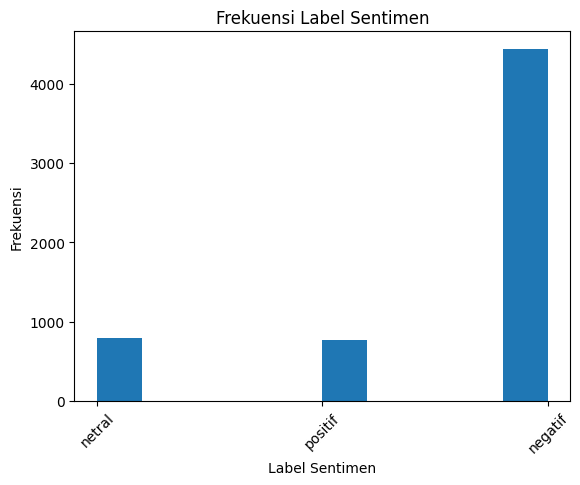

In [8]:
plt.hist(df.sentiment)
plt.xticks(rotation=45)
plt.title('Frekuensi Label Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Frekuensi')

# **PRE-PROCESING**

In [9]:
def case_folding(text):
    text = text.lower()
    return text
df['casefolding']= df['komentar'].apply(lambda x: case_folding(x))

In [10]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # simbol & pictogram
        u"\U0001F680-\U0001F6FF"  # transport & map symbol
        u"\U0001F1E0-\U0001F1FF"  # flags (bendera)
        u"\U00002700-\U000027BF"  # simbol lainnya
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [11]:
#Cleansing Data
def cleansing(text):
    text = remove_emoji(text) #hapus emoji
    text = re.sub('\[.*?\]', '', text) #Menghilangkan tanda kurung
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Menghilangkan Tanda Baca
    text = re.sub('\w*\d\w*', '', text) #Menghilangkan Special Karakter
    text = re.sub('\s+[a-zA-Z]\s+', '', text) #Menghilangkan Single Character
    text = re.sub(r"http\S+", "", text, flags=re.MULTILINE) #Menghilangkan Link
    text = re.sub(r'\B#\S+','', text)  #Menghilangkan Hashtag
    text = re.sub(r'\s+', ' ', text, flags=re.I) #Mengganti Multiple Spaces ke Single Spaces
    text = text.strip() #Menghilangkan Spaces di awal
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    return text
df['cleansing'] = df['casefolding'].apply(lambda x: x.split())

In [12]:
def tokenization(text):
    tokens = re.split(r'\W+', text)
    tokens = [word for word in tokens if word]
    return tokens

df['tokenizing'] = df['cleansing'].apply(lambda x: tokenization(str(x)))

In [13]:
def stopwords_removal(words):

    list_stopwords = ['yang', 'di', 'dan', 'itu', 'dengan', 'atau','untuk', 'dari', 'pada']
    return [word for word in words if word not in list_stopwords]

df['stop_removal']= df['tokenizing'].apply(stopwords_removal)

In [15]:
#Stemming
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['stop_removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['stemming'] = df['stop_removal'].apply(get_stemmed_term)
df.head()

Streaming output truncated to the last 5000 lines.
cut : cut
other : other
channels : channels
sudahi : sudah
adudomba : adudomba
intropeksi : intropeksi
kitaaaa : kitaaaa
tapiketika : tapiketika
urusannya : urus
sadari : sadar
tangannya : tangan
awal2 : awal2
moga : moga
varian : varian
disiplin : disiplin
trkadang : trkadang
brasa : brasa
eyangnya : eyang
dibilangin : dibilangin
nyela : nyela
briefing : briefing
kelen : kelen
aba2 : aba2
hhhh : hhhh
kuesioner : kuesioner
mengkambing : kambing
hitamkan : hitam
abad : abad
dijajah : jajah
surah : surah
nam : nam
ayat : ayat
123 : 123
lihatlah : lihat
statistik : statistik
mlompong : mlompong
reforma : reforma
industrilialisasi : industrilialisasi
khusunya : khusunya
hapuskan : hapus
kebudayaan : budaya
feodalisme : feodalisme
wakili : wakil
mks : mks
memerintah : perintah
terpampang : pampang
artis2 : artis2
endors : endors
terketuk : ketuk
blk : blk
nitip : nitip
ngatasi : ngatasi
diprediksi : prediksi
cepetin : cepetin
nduddd : ndudd

komentar  label sentiment  \
0  Sangat keren! Meraih kemenangan besar diüö¶ùêè ùêã ùêî...      1    netral   
1   üî•ùó£ ùóü ùó® ùóß ùó¢ ùü¥ ùü¥ üî• memang layak jadi pilihan utama      2   positif   
2                               NYESEL PILIH PRABOWO      0   negatif   
3         ekspresinya so iye\npembahasannya walaweee      0   negatif   
4  Yang komen kenapa parah banget literasinya?mes...      2   positif   

                                         casefolding  \
0  sangat keren! meraih kemenangan besar diüö¶ùêè ùêã ùêî...   
1   üî•ùó£ ùóü ùó® ùóß ùó¢ ùü¥ ùü¥ üî• memang layak jadi pilihan utama   
2                               nyesel pilih prabowo   
3         ekspresinya so iye\npembahasannya walaweee   
4  yang komen kenapa parah banget literasinya?mes...   

                                           cleansing  \
0  [sangat, keren!, meraih, kemenangan, besar, di...   
1  [üî•ùó£, ùóü, ùó®, ùóß, ùó¢, ùü¥, ùü¥, üî•, memang, layak, jadi,...   
2                           [nyesel, pilih, prabowo]   
3    [ekspresinya, so, iye, pembahasannya, walaweee]   
4  [yang, komen, kenapa, parah, banget, literasin...   

                                          tokenizing  \
0  [sangat, keren, meraih, kemenangan, besar, di,...   
1  [ùó£, ùóü, ùó®, ùóß, ùó¢, ùü¥, ùü¥, memang, layak, jadi, pil...   
2                           [nyesel, pilih, prabowo]   
3    [ekspresinya, so, iye, pembahasannya, walaweee]   
4  [yang, komen, kenapa, parah, banget, literasin...   

                                        stop_removal  \
0  [sangat, keren, meraih, kemenangan, besar, ùêè, ...   
1  [ùó£, ùóü, ùó®, ùóß, ùó¢, ùü¥, ùü¥, memang, layak, jadi, pil...   
2                           [nyesel, pilih, prabowo]   
3    [ekspresinya, so, iye, pembahasannya, walaweee]   
4  [komen, kenapa, parah, banget, literasinya, me...   

                                            stemming  
0  [sangat, keren, raih, menang, besar, , , , , ,...  
1  [, , , , , , , memang, layak, jadi, pilih, utama]  
2                           [nyesel, pilih, prabowo]  
3               [ekspresi, so, iye, bahas, walaweee]  
4  [komen, kenapa, parah, banget, literasinya, me...

In [16]:
def normalisasi(document):
  return ' '.join(document)
df['normalisasi'] = df['stemming'].apply(normalisasi)
df.head()

komentar  label sentiment  \
0  Sangat keren! Meraih kemenangan besar diüö¶ùêè ùêã ùêî...      1    netral   
1   üî•ùó£ ùóü ùó® ùóß ùó¢ ùü¥ ùü¥ üî• memang layak jadi pilihan utama      2   positif   
2                               NYESEL PILIH PRABOWO      0   negatif   
3         ekspresinya so iye\npembahasannya walaweee      0   negatif   
4  Yang komen kenapa parah banget literasinya?mes...      2   positif   

                                         casefolding  \
0  sangat keren! meraih kemenangan besar diüö¶ùêè ùêã ùêî...   
1   üî•ùó£ ùóü ùó® ùóß ùó¢ ùü¥ ùü¥ üî• memang layak jadi pilihan utama   
2                               nyesel pilih prabowo   
3         ekspresinya so iye\npembahasannya walaweee   
4  yang komen kenapa parah banget literasinya?mes...   

                                           cleansing  \
0  [sangat, keren!, meraih, kemenangan, besar, di...   
1  [üî•ùó£, ùóü, ùó®, ùóß, ùó¢, ùü¥, ùü¥, üî•, memang, layak, jadi,...   
2                           [nyesel, pilih, prabowo]   
3    [ekspresinya, so, iye, pembahasannya, walaweee]   
4  [yang, komen, kenapa, parah, banget, literasin...   

                                          tokenizing  \
0  [sangat, keren, meraih, kemenangan, besar, di,...   
1  [ùó£, ùóü, ùó®, ùóß, ùó¢, ùü¥, ùü¥, memang, layak, jadi, pil...   
2                           [nyesel, pilih, prabowo]   
3    [ekspresinya, so, iye, pembahasannya, walaweee]   
4  [yang, komen, kenapa, parah, banget, literasin...   

                                        stop_removal  \
0  [sangat, keren, meraih, kemenangan, besar, ùêè, ...   
1  [ùó£, ùóü, ùó®, ùóß, ùó¢, ùü¥, ùü¥, memang, layak, jadi, pil...   
2                           [nyesel, pilih, prabowo]   
3    [ekspresinya, so, iye, pembahasannya, walaweee]   
4  [komen, kenapa, parah, banget, literasinya, me...   

                                            stemming  \
0  [sangat, keren, raih, menang, besar, , , , , ,...   
1  [, , , , , , , memang, layak, jadi, pilih, utama]   
2                           [nyesel, pilih, prabowo]   
3               [ekspresi, so, iye, bahas, walaweee]   
4  [komen, kenapa, parah, banget, literasinya, me...   

                                         normalisasi  
0  sangat keren raih menang besar        langsung...  
1                      memang layak jadi pilih utama  
2                               nyesel pilih prabowo  
3                     ekspresi so iye bahas walaweee  
4  komen kenapa parah banget literasinya meski p ...

In [17]:
slang_dict = ({
    'bener': 'benar',
    'setuju': 'setuju',
    'cocok': 'sesuai',
    'keren': 'hebat',
    'mantap': 'baik',
    'tepuk tangan': 'apresiasi',
    'oke': 'baik',
    'bagus': 'positif',
    'sukses': 'berhasil',
    'semangat': 'antusias',
    'hebat': 'luar biasa',
    'wajib': 'perlu',
    'top': 'terbaik',
    'gokil': 'hebat',
    'diperjuangkan': 'diperjuangkan',
    'yakin': 'percaya',
    'berharap': 'mengharapkan',
    'nyata': 'terbukti',
    'senang': 'bahagia',
    'maju': 'berkembang',
    'berhasil': 'sukses',
    'sangat setuju': 'setuju sekali',
    'terimakasih': 'terima kasih',
    'berbahagia': 'senang',
    'klop': 'cocok',
    'langsung': 'segera',
    'inovasi': 'perubahan baru',
    'komitmen': 'tanggung jawab',
    'dapat diterima': 'memadai',
    'positif': 'baik',
    'bisa': 'mampu',
    'mendukung': 'mendukung',
    'percaya diri': 'yakin',
    'harapan': 'keinginan',
    'terbaik': 'paling baik',
    'indah': 'bagus',
    'sejahtera': 'makmur',
    'kecewa': 'frustrasi',
    'tidak setuju': 'kurang setuju',
    'masalah': 'permasalahan',
    'kritik': 'komentar',
    'serius': 'penting',
    'bermain politik': 'mengambil langkah politik',
    'korupsi': 'penyalahgunaan',
    'penuh tekanan': 'tertekan',
    'rakyat': 'masyarakat',
    'bangga': 'terhormat',
    'optimis': 'positif',
    'percaya': 'yakin',
    'perhatian': 'peduli',
    'bagus banget': 'sangat baik',
    'sangat penting': 'krusial',
    'belum jelas': 'belum pasti',
    'risih': 'tidak nyaman',
    'menginginkan': 'berharap',
    'realistis': 'dapat diterima',
    'kinerja': 'hasil kerja',
    'politik': 'politik',
    'kompromi': 'penyelesaian',
    'aspirasi': 'keinginan',
    'ke depan': 'untuk masa depan',
    'tidak nyaman': 'kurang menyenangkan',
    'tanggapan': 'respon',
    'perubahan': 'transformasi',
    'progres': 'kemajuan',
    'solusi': 'jawaban',
    'alternatif': 'pilihan',
    'berani': 'tangguh',
    'tegas': 'jelas',
    'harus': 'perlu',
    'rencana': 'strategi',
    'kedepannya': 'di masa depan',
    'bagus lah': 'oke lah',
    'jadi lebih baik': 'makin baik',
    'kerja keras': 'usaha keras',
    'asli': 'benar-benar',
    'selesai': 'tuntas',
    'tanggung jawab': 'amanah',
    'aman': 'terjaga',
    'berat': 'sulit',
    'terlalu lama': 'proses lama',
    'perbaikan': 'peningkatan',
    'menyelesaikan': 'mengakhiri',
    'wajib dilakukan': 'perlu diadakan',
    'baru': 'fresh',
    'terlalu cepat': 'terburu-buru',
    'terlalu lambat': 'terlalu lama',
    'kecewa banget': 'sangat kecewa',
    'kerja sama': 'kolaborasi',
    'apresiasi': 'penghargaan',
    'penurunan': 'kemunduran',
    'kemajuan': 'progres',
    'tindak lanjut': 'lanjutan',
    'transparansi': 'keterbukaan',
    'terus terang': 'jujur',
    'kontroversial': 'perdebatan',
    'bermanfaat': 'berguna',
    'di luar dugaan': 'terkejut',
    'terlalu ambisius': 'terlalu berlebihan',
    'agresif': 'berani',
    'strategis': 'penting',
    'komunikasi': 'interaksi',
    'positif sekali': 'sangat baik',
    'kurang transparan': 'tidak terbuka',
    'mendalam': 'detail',
    'pragmatis': 'praktis',
    'pertumbuhan': 'perkembangan',
    'tidak adil': 'kurang seimbang',
    'berkelanjutan': 'terus-menerus',
    'ideal': 'terbaik',
    'tangguh': 'kuat',
    'berkelanjutan': 'terus menerus',
    'fokus': 'terarah',
    'integritas': 'kejujuran',
    'progresif': 'berkembang',
    'hasil maksimal': 'pencapaian tinggi',
})

    # tambahkan lebih banyak sesuai kebutuhan

# Fungsi normalisasi
def normalize_text(text):
    # Pisahkan teks menjadi kata-kata
    words = text.split()

    # Normalisasi setiap kata
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]

    # Gabungkan kata-kata kembali menjadi satu string
    normalized_text = ' '.join(normalized_words)

    return normalized_text

df['normalisasi'] = df['normalisasi'].apply(normalize_text)

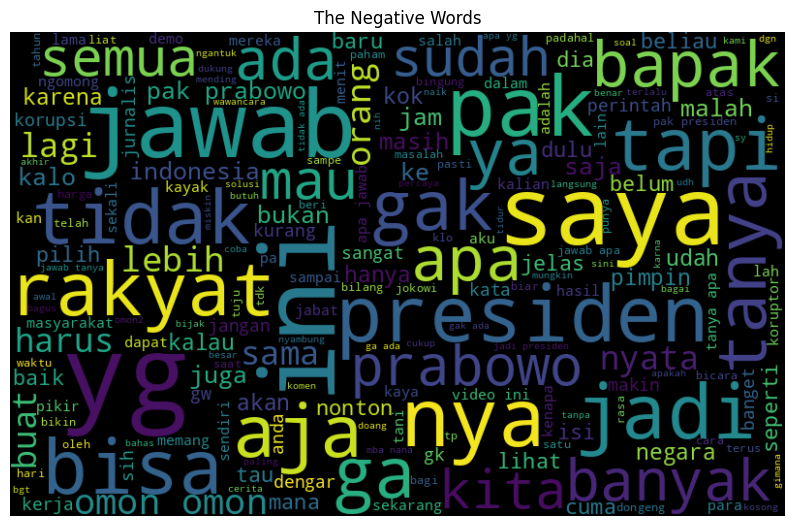

In [18]:
negative_words = ' '.join([word for sublist in df['stemming'][df['sentiment'] == 'negatif'] for word in sublist])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

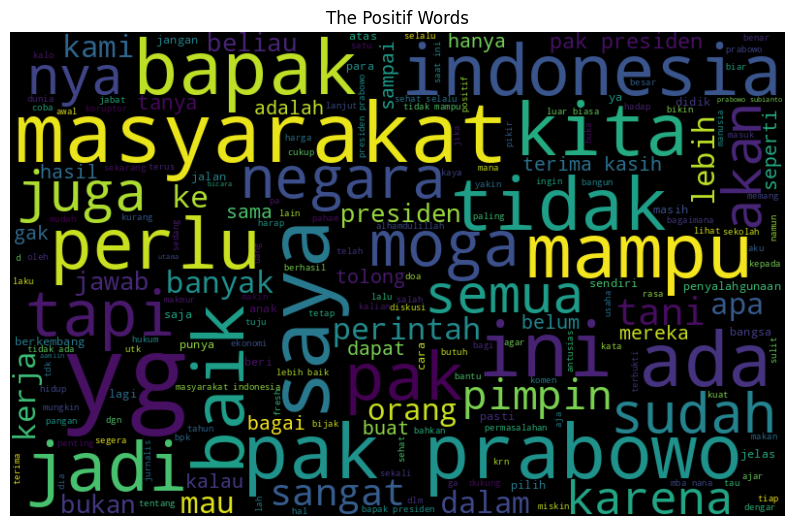

In [19]:
positif_words =' '.join([text for text in df['normalisasi'][df['sentiment'] == 'positif']])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(positif_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positif Words')
plt.show()

In [20]:
x = df['normalisasi']  # Teks hasil preprocessing
y = df['label']        # Label numerik: 0=Negatif, 1=Netral, 2=Positif

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# **PEMBOBOTAN TF-IDF**

In [31]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(x_train)   # Fit hanya di data training

Train_X_Tfidf = Tfidf_vect.transform(x_train)
Test_X_Tfidf = Tfidf_vect.transform(x_test)

In [32]:
Train_X_Tfidf.shape

(4797, 8570)

In [33]:
y_train.shape

(4797,)

In [34]:
print(Train_X_Tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 64573 stored elements and shape (4797, 8570)>
  Coords	Values
  (0, 99)	0.5110005763317093
  (0, 122)	0.5416146182135042
  (0, 257)	0.2366154165908299
  (0, 3261)	0.2273687359995916
  (0, 5499)	0.2671630233451618
  (0, 6936)	0.5162097808107378
  (1, 975)	0.14391657862412185
  (1, 2393)	0.2049719008261284
  (1, 2555)	0.1690955142589255
  (1, 2560)	0.22326637160248725
  (1, 2780)	0.14592529736410437
  (1, 3197)	0.16014160022579943
  (1, 3198)	0.10775990549880658
  (1, 3797)	0.23021156689563077
  (1, 4122)	0.13145927513837785
  (1, 4311)	0.27335906103138524
  (1, 5196)	0.18907279149985884
  (1, 5583)	0.20675091861278083
  (1, 5612)	0.2698038683125942
  (1, 6270)	0.1868744929702343
  (1, 6816)	0.1562941976901053
  (1, 7054)	0.260739227996634
  (1, 7639)	0.27335906103138524
  (1, 7847)	0.17317368217358925
  (1, 8253)	0.521478455993268
  :	:
  (4794, 7557)	0.32747736794242915
  (4794, 7871)	0.32287545878080004
  (4794, 8519)	0.167

In [27]:
print(Test_X_Tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15114 stored elements and shape (1200, 8570)>
  Coords	Values
  (0, 245)	0.3113674138656785
  (0, 1743)	0.3319744166721877
  (0, 2769)	0.4745745431561252
  (0, 2800)	0.4745745431561252
  (0, 3070)	0.14742597882644937
  (0, 6094)	0.3214832947453541
  (0, 6907)	0.2665337670712325
  (0, 7326)	0.38245934321392044
  (1, 2612)	0.6143821748171208
  (1, 3045)	0.3005264531482286
  (1, 4378)	0.7295329973518199
  (2, 1545)	0.7638564333348041
  (2, 2806)	0.6453862016289408
  (3, 1788)	0.21912038599740852
  (3, 2003)	0.21643508197303493
  (3, 2966)	0.5051938238793968
  (3, 3573)	0.19322934986350834
  (3, 4487)	0.12887696774423144
  (3, 5583)	0.2525969119396984
  (3, 5883)	0.27678102450697684
  (3, 6171)	0.24836744528772375
  (3, 7150)	0.6152349233143184
  (3, 7868)	0.12393999914972802
  (4, 272)	0.5657108202923765
  (4, 1073)	0.24669024454159982
  :	:
  (1198, 2374)	0.21912248202554357
  (1198, 2512)	0.4457774635922777
  (1198, 4978)	0.3

# **NAIVE BAYES**

In [44]:
hyperparameters = {
  'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # smoothing parameter
  'fit_prior': [True, False]}          # apakah model menghitung prior kelas dari data
nb = MultinomialNB()
nb_tuned = GridSearchCV(nb, hyperparameters, cv=5, scoring='accuracy', n_jobs=-1)

In [45]:
nb_tuned.fit(Train_X_Tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [46]:
filename = 'model_nb_AS.pkl'
pickle.dump(nb_tuned.best_estimator_, open(filename, 'wb'))

In [47]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Test_X_Tfidf, y_test)
print(result)

0.7875


# **EVALUASI**

In [49]:
# HASIL AKURASI, RECALL, PRECISSION, F1 SCORE
y_pred = loaded_model.predict(Test_X_Tfidf)

print("NB Accuracy Score = ", accuracy_score(y_test, y_pred)*100)
print("NB Precision Score = ", precision_score(y_test, y_pred, average='weighted')*100)
print("NB Recall Score = ", recall_score(y_test, y_pred, average='weighted')*100)
print("NB F1 Score = ", f1_score(y_test, y_pred, average='weighted')*100)

NB Accuracy Score =  78.75
NB Precision Score =  76.96442774262736
NB Recall Score =  78.75
NB F1 Score =  74.17721992745182


In [50]:
report = classification_report(y_test, y_pred)
print(report) # print classification_report

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       888
           1       0.61      0.14      0.23       159
           2       0.80      0.37      0.51       153

    accuracy                           0.79      1200
   macro avg       0.74      0.50      0.54      1200
weighted avg       0.77      0.79      0.74      1200



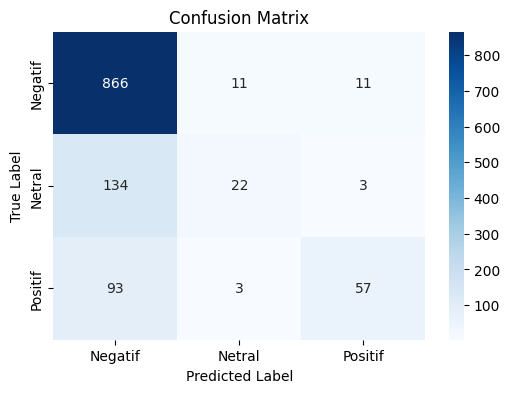

In [51]:
cm = confusion_matrix(y_test, y_pred)

label = ['Negatif', 'Netral', 'Positif']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()